# ALS Project - Modeling

### Random Forest Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from linear_model import LinearModel
from linear_plotting import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def plot_model_parallel(y_test, y_predicted, units='units'):
    data = pd.DataFrame(y_test.values, columns=["test"])
    data['predicted']=y_predicted
    data['result']='result'
    parallel_coordinates(data, 'result',colormap=plt.get_cmap("Set2"))
    plt.title("Results of Model")
    plt.ylabel(units)
    plt.show()

### data = txt, death, riluzole, onset dates, demo

In [5]:
# load data
df = pd.read_csv("data/tdrod.csv")

In [6]:
print(df.shape)
df.head()

(9640, 23)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset,death_week,death_month,...,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,NaN,NaN,NaN,...,0,1,0,NaN,0,0,NaN,0.0,38.0,13870.0
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,NaN,NaN,NaN,...,0,0,0,NaN,1,0,NaN,0.0,52.0,18980.0
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,NaN,1.0,NaN,NaN


### Add scale linear coeff

In [28]:
scale_assess = pd.read_csv("clean_data/scale_assess_slope.csv")

In [29]:
print(scale_assess.shape)
scale_assess.head()

(6537, 4)


,subject_id,scale,slope,intercept
0,329,original,-0.007092,40.084327
1,348,revised,-0.012720,46.428161
2,533,revised,-0.010940,48.231426
3,586,revised,-0.012535,48.000000
4,649,original,-0.020465,43.366399


In [30]:
# merge with previous data
df = df.merge(scale_assess, how='left', on='subject_id')

In [32]:
print(df.shape)
df.head()

(9640, 26)


,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset,death_week,death_month,...,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days,scale,slope,intercept
0,89,Active,1.0,218.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,329,Active,NaN,NaN,NaN,-1706.0,-1068.0,NaN,NaN,NaN,...,NaN,0,0,NaN,0.0,38.0,13870.0,original,-0.007092,40.084327
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,NaN,NaN,NaN,...,NaN,1,0,NaN,0.0,52.0,18980.0,revised,-0.012720,46.428161
3,406,Active,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,411,Active,1.0,141.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


## clean up the data

In [33]:
df.columns

Index(['subject_id', 'Study_Arm', 'Subject_Died', 'death_days_trail_start',
       'Subject_used_Riluzole', 'Onset_Delta', 'Diagnosis_Delta',
       'death_day_since_onset', 'death_week', 'death_month', 'Age',
       'Ethnicity', 'Race_Americ_Indian_Alaska_Native', 'Race_Asian',
       'Race_Black_African_American', 'Race_Hawaiian_Pacific_Islander',
       'Race_Unknown', 'Race_Caucasian', 'Race_Other', 'Race_Other_Specify',
       'sex', 'age_trial_start_years', 'age_trial_start_days', 'scale',
       'slope', 'intercept'],
      dtype='object')

In [34]:
# limit to placebo subjects.
placebo = df[ df['Study_Arm']=='Placebo' ].copy()

In [35]:
placebo.head()

,subject_id,Study_Arm,Subject_Died,death_days_trail_start,Subject_used_Riluzole,Onset_Delta,Diagnosis_Delta,death_day_since_onset,death_week,death_month,...,Race_Unknown,Race_Caucasian,Race_Other,Race_Other_Specify,sex,age_trial_start_years,age_trial_start_days,scale,slope,intercept
2,348,Placebo,NaN,NaN,1.0,-501.0,-302.0,NaN,NaN,NaN,...,NaN,1,0,NaN,0.0,52.0,18980.0,revised,-0.012720,46.428161
7,902,Placebo,0.0,NaN,1.0,-514.0,-49.0,NaN,NaN,NaN,...,NaN,1,0,NaN,0.0,76.8,28032.0,revised,-0.014862,48.309915
9,1064,Placebo,NaN,NaN,1.0,-550.0,-462.0,NaN,NaN,NaN,...,NaN,1,0,NaN,0.0,66.0,24090.0,revised,-0.033519,55.259988
11,1312,Placebo,0.0,NaN,0.0,-247.0,-63.0,NaN,NaN,NaN,...,NaN,0,0,NaN,0.0,67.0,24455.0,revised,-0.032389,48.000000
16,2132,Placebo,1.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,0,0,NaN,1.0,65.0,23725.0,NaN,NaN,NaN


In [36]:
# test X with random rows
X1 = placebo[['Subject_used_Riluzole', 'age_trial_start_years', 'death_day_since_onset',
              'Race_Americ_Indian_Alaska_Native', 'Race_Asian', 'Race_Black_African_American',
              'Race_Hawaiian_Pacific_Islander', 'Race_Caucasian', 'slope']].copy()

In [37]:
# get rid of the nans
X1.dropna(axis=0, inplace=True)

In [38]:
print(X1.shape)
X1.head()

(459, 9)


,Subject_used_Riluzole,age_trial_start_years,death_day_since_onset,Race_Americ_Indian_Alaska_Native,Race_Asian,Race_Black_African_American,Race_Hawaiian_Pacific_Islander,Race_Caucasian,slope
22,1.0,41.0,405.0,0,0,0,0,1,-0.053054
32,1.0,60.0,624.0,0,0,0,0,1,-0.037167
65,1.0,70.0,656.0,0,0,0,0,1,-0.012011
68,1.0,65.0,706.0,0,0,0,0,1,-0.040901
77,1.0,52.0,1781.0,0,0,0,0,1,-0.006964


#### split data

In [39]:
# assign target, features
y = X1['death_day_since_onset']
X = X1.drop('death_day_since_onset', axis=1)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)

#### Random Forest 

In [41]:
model = RandomForestRegressor()
model.fit(X_train,y_train)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
# why does this not work?
#model.oob_score_

In [44]:
# score - R2
model.score(X_test, y_test.values)

0.32450233900402237

In [45]:
# predicted y values
y_predicted = model.predict(X_test)

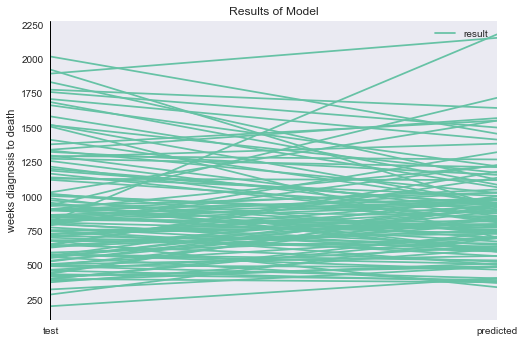

In [46]:
# plot the 
plot_model_parallel(y_test, y_predicted, 'weeks diagnosis to death')

#### Linear Model

In [47]:
lm = LinearModel('linear', X, y)

/Users/Shared/galvanize/als/linear_model.py:173: RuntimeWarning: invalid value encountered in log
  self.rmse_log = np.sqrt(((( np.log(self.predicted+1)-np.log(self.y_train + 1) )**2).sum() ) / len(self.y_train))


In [48]:
lm.r2_adj

0.38393060663599465

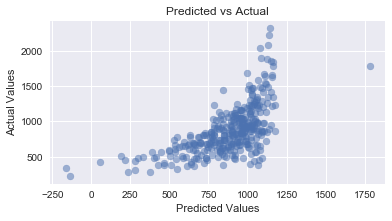

In [49]:
lm_plot(lm.predicted, lm.y_train)

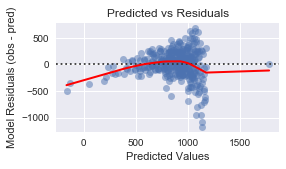

In [50]:
resid_plot(lm.predicted, lm.resid)